In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
from fancyimpute import KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
import json
import os
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from imblearn.combine import SMOTEENN
import time

## Data Preprocessing

In [2]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'


In [3]:
# Read Files
transactions = pd.read_csv('../data/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
identities = pd.read_csv('../data/train_identity.csv',index_col='TransactionID', dtype=dtypes)
full_df = transactions.merge(identities, how='left', left_index=True, right_index=True)

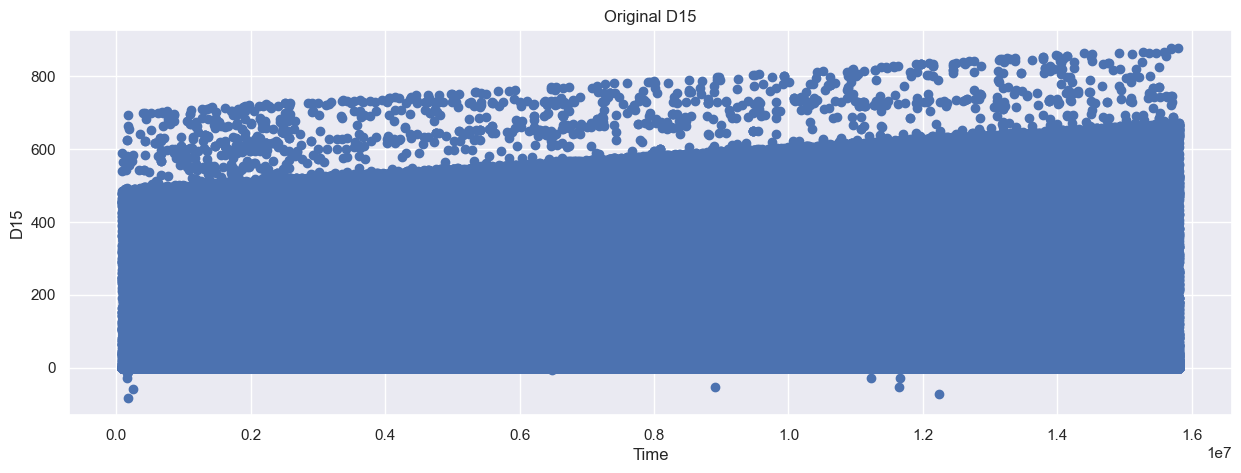

In [4]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(full_df.TransactionDT,full_df.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [5]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    full_df['D'+str(i)] =  full_df['D'+str(i)] - full_df.TransactionDT/np.float32(24*60*60)

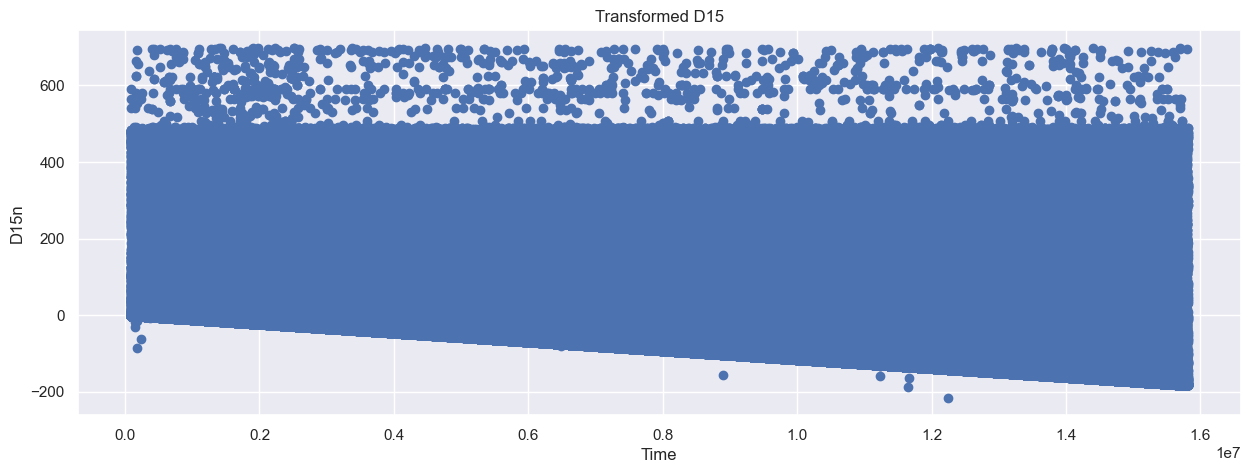

In [6]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(full_df.TransactionDT,full_df.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [7]:
# Check for missing values
missing_values = full_df.isnull().sum().sort_values(ascending=False)/len(full_df)
missing_values = missing_values[missing_values > 0]
print("\nColumns with missing values:\n", missing_values)


Columns with missing values:
 id_24    0.991962
id_25    0.991310
id_08    0.991271
id_07    0.991271
id_21    0.991264
           ...   
V307     0.000020
V305     0.000020
V303     0.000020
V297     0.000020
V286     0.000020
Length: 195, dtype: float64


In [8]:
missing_values['addr1']

0.1112642666034477

In [9]:
full_df.shape

(590540, 214)

In [10]:
# Drop columns that have more than 90% missing values
threshold = len(full_df) * 0.1  # 10% of the total number of rows
full_df = full_df.dropna(axis=1, thresh=threshold)

In [11]:
full_df.shape

(590540, 202)

## Train Test Split

In [12]:
# Train Test Split 

# Determine the index for the split based on the test size
split_index = int(len(full_df) * 0.8)  # 80% for training, 20% for testing

target = 'isFraud'
# Perform the time series split
X_train = full_df.iloc[:split_index].drop(columns=[target])
X_test = full_df.iloc[split_index:].drop(columns=[target])
y_train = full_df.iloc[:split_index][target]
y_test = full_df.iloc[split_index:][target]

# Check the shapes of the resulting datasets
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (472432, 201)
Testing features shape: (118108, 201)
Training target shape: (472432,)
Testing target shape: (118108,)


## Feature Engineering

In [13]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [14]:
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , 

In [15]:
M_cols = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

for col in M_cols:
    # missing flag
    X_train[f'{col}_missing_flag'] = X_train[col].isnull().astype(int)
    X_test[f'{col}_missing_flag'] = X_test[col].isnull().astype(int)

    # If the column is categorical, add 'missing' to its categories
    if pd.api.types.is_categorical_dtype(X_train[col]):
        X_train[col] = X_train[col].cat.add_categories('missing')
        X_test[col] = X_test[col].cat.add_categories('missing')

    # Fill NA with 'missing'
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')


In [16]:
# Sender parent domain, e.g. gmail, hotmail
X_train['P_pdomain'] = X_train['P_emaildomain'].str.split(".", n=1).str[0]
X_test['P_pdomain'] = X_test['P_emaildomain'].str.split(".", n=1).str[0]
# Sender top-level domain e.g. com, net, co.uk
X_train['P_tldomain'] = X_train['P_emaildomain'].str.split(".", n=1).str[1]
X_test['P_tldomain'] = X_test['P_emaildomain'].str.split(".", n=1).str[1]

# Receipient parent domain, e.g. gmail, hotmail
X_train['R_pdomain'] = X_train['R_emaildomain'].str.split(".", n=1).str[0]
X_test['R_pdomain'] = X_test['R_emaildomain'].str.split(".", n=1).str[0]
# Receipient top-level domain e.g. com, net, co.uk
X_train['R_tldomain'] = X_train['R_emaildomain'].str.split(".", n=1).str[1]
X_test['R_tldomain'] = X_test['R_emaildomain'].str.split(".", n=1).str[1]

In [17]:
# Align categories for categorical columns
if X_train['P_emaildomain'].dtype.name == 'category' and X_train['R_emaildomain'].dtype.name == 'category':
    categories_union = X_train['P_emaildomain'].cat.categories.union(X_train['R_emaildomain'].cat.categories)
    X_train['P_emaildomain'] = X_train['P_emaildomain'].cat.set_categories(categories_union)
    X_train['R_emaildomain'] = X_train['R_emaildomain'].cat.set_categories(categories_union)
    X_test['P_emaildomain'] = X_test['P_emaildomain'].cat.set_categories(categories_union)
    X_test['R_emaildomain'] = X_test['R_emaildomain'].cat.set_categories(categories_union)

# Now you can safely compare them
X_train['emaildomainMatch'] = (X_train['P_emaildomain'] == X_train['R_emaildomain']).astype(int)
X_test['emaildomainMatch'] = (X_test['P_emaildomain'] == X_test['R_emaildomain']).astype(int)


In [18]:
# Reducing cardinality of 'id_31'
browser_names = ['chrome', 'safari', 'ie', 'edge', 'firefox', 'other', 'android webview',
                 'opera', 'Generic/Android', 'google', 'Microsoft/Windows', 'silk', 'samsung', 'Samsung']


# Ensure 'id_31' is a categorical column in both datasets
X_train['id_31'] = X_train['id_31'].astype('category')
X_test['id_31'] = X_test['id_31'].astype('category')

# Add new categories if necessary
new_categories = list(set(browser_names) - set(X_train['id_31'].cat.categories))
X_train['id_31'] = X_train['id_31'].cat.add_categories(new_categories)
X_test['id_31'] = X_test['id_31'].cat.add_categories(new_categories)

# Shorten browser names in both datasets
for browser in browser_names:
    X_train.loc[X_train['id_31'].str.contains(browser, na=False), 'id_31'] = browser
    X_test.loc[X_test['id_31'].str.contains(browser, na=False), 'id_31'] = browser

# Replace 'Samsung' with 'samsung'
X_train['id_31'].replace('Samsung', 'samsung', inplace=True)
X_test['id_31'].replace('Samsung', 'samsung', inplace=True)

# Group rare browser names as 'other', leaving null as null
X_train['id_31'] = X_train['id_31'].apply(lambda x: x if pd.isna(x) or x in browser_names else 'other')
X_test['id_31'] = X_test['id_31'].apply(lambda x: x if pd.isna(x) or x in browser_names else 'other')

In [19]:
### DeviceInfo
# Extracts the device name from 'DeviceInfo'. E.g Samsung. Then converts to lowercase.
X_train['DeviceInfo'] = X_train['DeviceInfo'].str.extract(r'(\S+)')[0].str.lower()
X_test['DeviceInfo'] = X_test['DeviceInfo'].str.extract(r'(\S+)')[0].str.lower()

device_regex = [
    (r'mot', 'motorola'),
    (r'mi|redmi', 'xiaomi'),
    (r'samsung|sgh|sm|gt-', 'samsung'),
    (r'rv:', 'rv'),
    (r'blade', 'zte'),
    (r'ilium', 'ilium'),
    (r'xt', 'sony'),
    (r'ale-|.*-l|hi', 'huawei'),
    (r'lenovo', 'lenovo'),
    (r'alcatel', 'alcatel'),
    (r'asus', 'asus'),
    (r'iphone', 'ios')
]

# Use regex to categorize 'DeviceInfo' into elements in device_regex
for regex, device in device_regex:
    X_train.loc[X_train['DeviceInfo'].str.contains(regex, na=False), 'DeviceInfo'] = device
    X_test.loc[X_test['DeviceInfo'].str.contains(regex, na=False), 'DeviceInfo'] = device

# Rare (=< 10 count) grouped as others
# leave null to be imputed by rf
value_counts_train = X_train['DeviceInfo'].value_counts()
value_counts_test = X_test['DeviceInfo'].value_counts()
X_train['DeviceInfo'] = X_train['DeviceInfo'].apply(lambda x: x if pd.isna(x) or value_counts_train[x] > 10 else 'other')
X_test['DeviceInfo'] = X_test['DeviceInfo'].apply(lambda x: x if pd.isna(x) or value_counts_test[x] > 10 else 'other')


In [20]:
### TransactionAmt
# Natural log of transaction amount
X_train['TransactionAmt_Log'] = np.log(X_train['TransactionAmt'])
X_test['TransactionAmt_Log'] = np.log(X_test['TransactionAmt'])

# Normalised transaction amount by card 1-6
for i in range (1,7):
    X_train[f'TransactionAmt_card{i}_mean'] = X_train['TransactionAmt'] / X_train.groupby([f'card{i}'])['TransactionAmt'].transform('mean')
    X_test[f'TransactionAmt_card{i}_mean'] = X_test['TransactionAmt'] / X_test.groupby([f'card{i}'])['TransactionAmt'].transform('mean')
# Normalised transaction amount by addr1, addr2
for addr in ['addr1', 'addr2']:
    X_train[f'TransactionAmt_{addr}_mean'] = X_train['TransactionAmt'] / X_train.groupby([addr])['TransactionAmt'].transform('mean')
    X_test[f'TransactionAmt_{addr}_mean'] = X_test['TransactionAmt'] / X_test.groupby([addr])['TransactionAmt'].transform('mean')

In [21]:
X_train['Transaction_day_of_week'] = np.floor((X_train['TransactionDT'] / (3600 * 24) - 1) % 7)
X_test['Transaction_day_of_week'] = np.floor((X_test['TransactionDT'] / (3600 * 24) - 1) % 7)
X_train['Transaction_hour'] = np.floor(X_train['TransactionDT'] / 3600) % 24
X_test['Transaction_hour'] = np.floor(X_test['TransactionDT'] / 3600) % 24

In [22]:
for feature in ['id_34', 'id_36']:
    # Count encoded for both train and test
    X_train[feature + '_count_full'] = X_train[feature].map(pd.concat([X_train[feature], X_test[feature]], ignore_index=True).value_counts(dropna=False))
    X_test[feature + '_count_full'] = X_test[feature].map(pd.concat([X_train[feature], X_test[feature]], ignore_index=True).value_counts(dropna=False))

for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    # Count encoded separately for train and test
    X_train[feature + '_count_dist'] = X_train[feature].map(X_train[feature].value_counts(dropna=False))
    X_test[feature + '_count_dist'] = X_test[feature].map(X_test[feature].value_counts(dropna=False))

In [24]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

In [28]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 


In [26]:
# Convert all categorical variables to numerical
for col in tqdm_notebook(X_train.columns):
    if X_train[col].dtype in ['object', 'category']:
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train[col] = le.transform(list(X_train[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))

  0%|          | 0/285 [00:00<?, ?it/s]

In [29]:
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15


In [30]:
X_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,uid_cents_ct,C14_uid_std,uid_C13_ct,uid_V314_ct,uid_V127_ct,uid_V136_ct,uid_V309_ct,uid_V307_ct,uid_V320_ct,outsider15
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000.0,86400.0,68.5,4,13926.0,NaN,150.0,1,142.0,1,315.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2987001.0,86401.0,29.0,4,2755.0,404.0,150.0,2,102.0,1,325.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2987002.0,86469.0,59.0,4,4663.0,490.0,150.0,4,166.0,2,330.0,...,1.0,0.0,4.0,1.0,2.0,1.0,1.0,2.0,1.0,1
2987003.0,86499.0,50.0,4,18132.0,567.0,150.0,2,117.0,2,476.0,...,1.0,0.0,23.0,1.0,82.0,10.0,9.0,81.0,10.0,0
2987004.0,86506.0,50.0,1,4497.0,514.0,150.0,2,102.0,1,420.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [31]:
X_train.shape, X_test.shape

((472432, 309), (118108, 309))

In [32]:
# Count rows with NaN values in X_train
nan_rows_train = X_train.isnull().any(axis=1).sum()
print(f"Number of rows with NaN values in X_train: {nan_rows_train}")

# Count rows with NaN values in X_test
nan_rows_test = X_test.isnull().any(axis=1).sum()
print(f"Number of rows with NaN values in X_test: {nan_rows_test}")


Number of rows with NaN values in X_train: 472432
Number of rows with NaN values in X_test: 118108


In [33]:
X_train.reset_index(drop= True, inplace=True)
X_test.reset_index(drop= True, inplace=True)

In [34]:
X_train = X_train.drop(['TransactionDT'], axis=1)
X_test = X_test.drop(['TransactionDT'], axis=1)

In [35]:
# Save Raw Files
X_train.to_csv('../data/output/X_train.csv')
X_test.to_csv('../data/output/X_test.csv')
y_train.to_csv('../data/output/y_train.csv')
y_test.to_csv('../data/output/y_test.csv')

### NAN Imputation

In [37]:
X_train.shape, X_test.shape

((472432, 308), (118108, 308))

In [38]:
# Check for missing values
missing_values = X_train.isnull().sum().sort_values(ascending=False)/len(full_df)
missing_values = missing_values[missing_values > 0]
print("\nColumns with missing values:\n", missing_values)


Columns with missing values:
 D13      0.717071
D14      0.715609
D12      0.710755
id_03    0.708406
id_04    0.708406
           ...   
V284     0.000020
V294     0.000020
V286     0.000020
V285     0.000020
V291     0.000020
Length: 166, dtype: float64


In [39]:
# Convert all categorical variables to numerical
for col in tqdm_notebook(X_train.columns):
    if X_train[col].dtype in ['object', 'category']:
        le = LabelEncoder()
        le.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        X_train[col] = le.transform(list(X_train[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))

  0%|          | 0/308 [00:00<?, ?it/s]

#### MICE Imputation

In [ ]:
# from sklearn.experimental import enable_iterative_imputer  # noqa
# from sklearn.impute import IterativeImputer
# from tqdm import tqdm

In [ ]:
# # Initialize the MICE imputer
# mice_imputer = IterativeImputer(max_iter=10, random_state=0, verbose = 2)

# # Fit on X_train and transform both X_train and X_test
# X_train_imputed = mice_imputer.fit_transform(X_train)
# X_test_imputed = mice_imputer.transform(X_test)

In [ ]:
# # Save Raw Files
# X_train.to_csv('../data/output/mice_imputed_X_train.csv')
# X_test.to_csv('../data/output/mice_imputed_X_test.csv')

#### RF Imputation

In [40]:
# Count of rows with NaN values in the training dataset
train_nan_count = X_train.isnull().any(axis=1).sum()
print(f"Number of rows with NaN values in the training dataset: {train_nan_count}")

# Count of rows with NaN values in the testing dataset
test_nan_count = X_test.isnull().any(axis=1).sum()
print(f"Number of rows with NaN values in the testing dataset: {test_nan_count}")


Number of rows with NaN values in the training dataset: 472432
Number of rows with NaN values in the testing dataset: 118108


In [41]:
sort_index = np.argsort(X_train.isnull().sum(axis=0)).values
sort_index

array([  0, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 217,
       229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 230,
       249, 216, 214, 182, 183, 187, 188, 189, 190, 192, 193, 194, 195,
       196, 215, 197, 199, 200, 202, 206, 207, 208, 209, 210, 211, 212,
       213, 198, 250, 251, 252, 282, 283, 284, 285, 286, 287, 288, 289,
       290, 291, 292, 281, 293, 295, 296, 297, 298, 299, 300, 301, 302,
       303, 304, 305, 294, 280, 279, 278, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 273, 274, 275, 276, 277, 179, 306, 307,  47,  49,  48,  46,
        45,  44,  43,  42,  41,  26,  25,  24,  23,  21,  20,  22,  18,
         1,   2,   5,   7,  19,  12,  11,  14,  15,  16,  17,  13, 154,
       155, 159, 163, 161, 164, 169, 166, 167, 156, 165, 158,  95,  94,
        96,  97,  89,  93,  92,  91,  90,  88,  87,  98,  99, 243,   4,
       204, 246, 244,  27, 153, 168, 152, 157, 162, 160,   6, 24

In [42]:
import time
for i in sort_index:
    # print(i)
    t = time.time()  # Record time

    # Construct new feature matrix and labels
    fillc = X_train.iloc[:, i]  # The feature to be filled, treated as a new target variable
    # Identify trainable data and the data to be filled
    ytrain = fillc[fillc.notnull()]
    ytest = fillc[fillc.isnull()]


    if len(ytest) == 0:
        continue

    print(f'Len of ytest: {len(ytest)}')
    print(fillc.head())

    df = pd.concat([X_train.iloc[:, :i], X_train.iloc[:, i + 1:]], axis=1)  # Remove new target variable

    # Fill missing values with 0 for the final feature matrix
    df_0 = df.fillna(0)
    Xtrain = df_0.iloc[ytrain.index, :]
    Xtest = df_0.iloc[ytest.index, :]

    # Train Random Forest and predict
    rfr = RandomForestRegressor(n_estimators=1, max_depth=10, max_features=80)
    rfr.fit(Xtrain, ytrain)

    # # Predict for the test set (the corresponding rows in the test set)
    ypredict_train = rfr.predict(Xtest)

    print('#########################')
    print(ypredict_train)

    X_train.iloc[X_train.iloc[:, i].isnull(), i] = ypredict_train  # Impute in the training DataFrame


    # NEW: Impute missing values in X_test using the trained model
    test_fillc = X_test.iloc[:, i]  # Feature in X_test to be filled
    test_ytest = test_fillc[test_fillc.isnull()]  # Identify missing rows in X_test

    if len(test_ytest) > 0:  # Only proceed if there are missing values in X_test
        Xtest_test_missing = pd.concat([X_test.iloc[:, :i], X_test.iloc[:, i + 1:]], axis=1)
        Xtest_test_missing = Xtest_test_missing.fillna(0).iloc[test_ytest.index, :]  # Fill NaNs in feature matrix
        ypredict_test = rfr.predict(Xtest_test_missing)  # Predict missing values for X_test
        print('Predicted values for X_test:', ypredict_test)

        # Impute missing values in X_test
        X_test.iloc[X_test.iloc[:, i].isnull(), i] = ypredict_test

Len of ytest: 12
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: V284, dtype: float32
#########################
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Len of ytest: 12
0     0.0
1     0.0
2     0.0
3    10.0
4     0.0
Name: V285, dtype: float32
#########################
[0.         0.         6.65384615 6.65384615 6.65384615 6.65384615
 0.         0.         0.         0.         0.         0.        ]
Len of ytest: 12
0     1.0
1     0.0
2     0.0
3    38.0
4     0.0
Name: V294, dtype: float32
#########################
[6.50000000e+02 6.17284595e-02 5.95757576e+01 5.95757576e+01
 5.95757576e+01 5.95757576e+01 6.49000000e+02 6.41000000e+02
 6.49000000e+02 6.17284595e-02 6.17284595e-02 6.17284595e-02]
Len of ytest: 12
0    0.0
1    0.0
2    0.0
3    0.0
4    1.0
Name: V303, dtype: float32
#########################
[8.00000000e+00 5.21376434e-04 5.78400780e-06 5.78400780e-06
 5.78400780e-06 5.78400780e-06 8.00000000e+00 1.09677419e+00
 8.00000000e+00 5.91715976e-03 5.91715976e-03 1.000

In [43]:
# Count of rows with NaN values in the training dataset
train_nan_count = X_train.isnull().any(axis=1).sum()
print(f"Number of rows with NaN values in the training dataset: {train_nan_count}")

# Count of rows with NaN values in the testing dataset
test_nan_count = X_test.isnull().any(axis=1).sum()
print(f"Number of rows with NaN values in the testing dataset: {test_nan_count}")


Number of rows with NaN values in the training dataset: 0
Number of rows with NaN values in the testing dataset: 0


In [44]:
X_train.to_csv('../data/output/rf_imputed_X_train.csv')
X_test.to_csv('../data/output/rf_imputed_X_test.csv')